# Labeling
perform the labeling exploiting the NMF routine

-> rep = 0
X | power: (8, 13625), pinch: (8, 9750), ulnar: (8, 9750)
R | power: (1, 13625), pinch: (1, 9750), ulnar: (1, 9750)


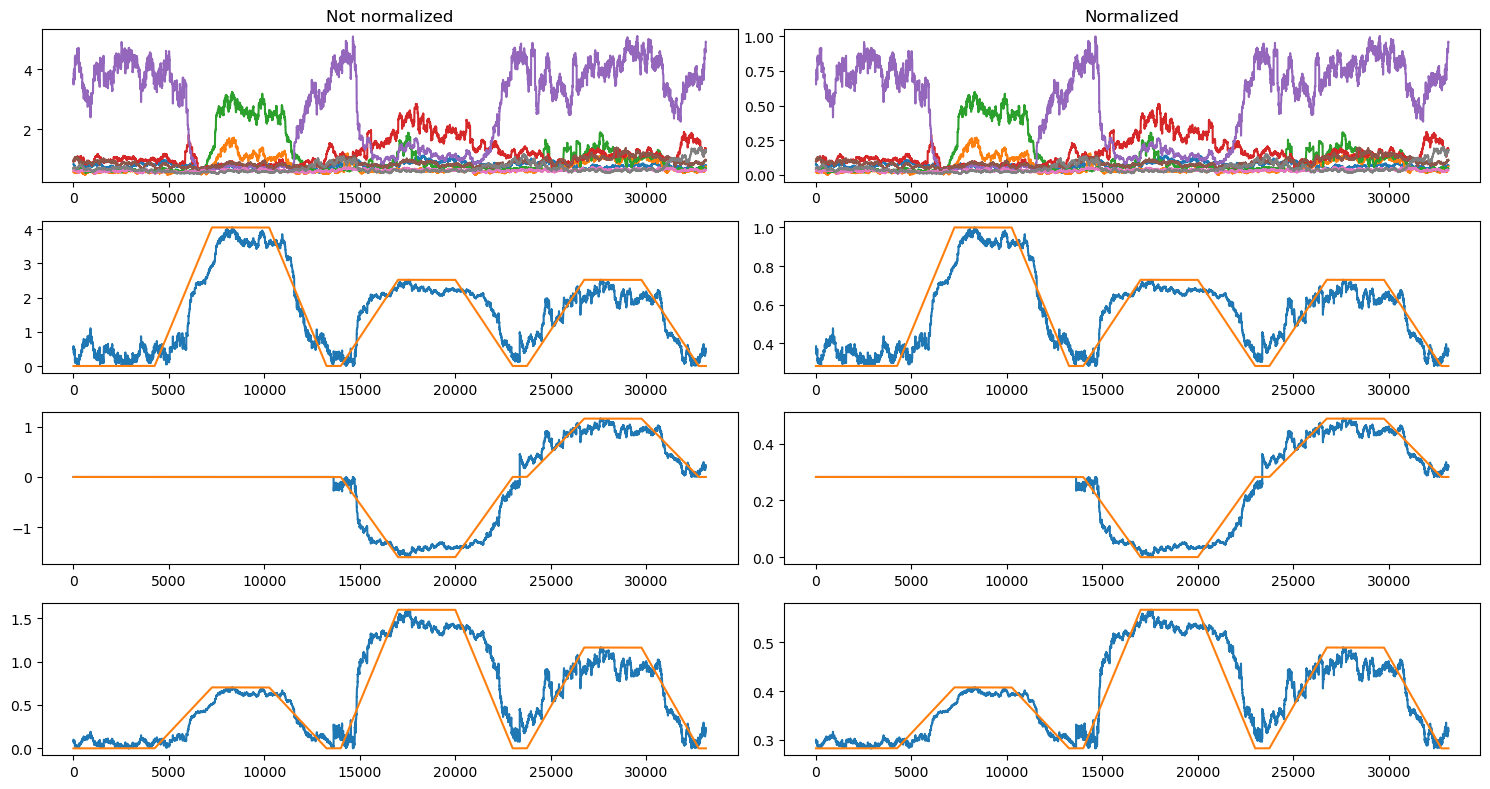

-> rep = 1
X | power: (8, 9750), pinch: (8, 9750), ulnar: (8, 9750)
R | power: (1, 9750), pinch: (1, 9750), ulnar: (1, 9750)


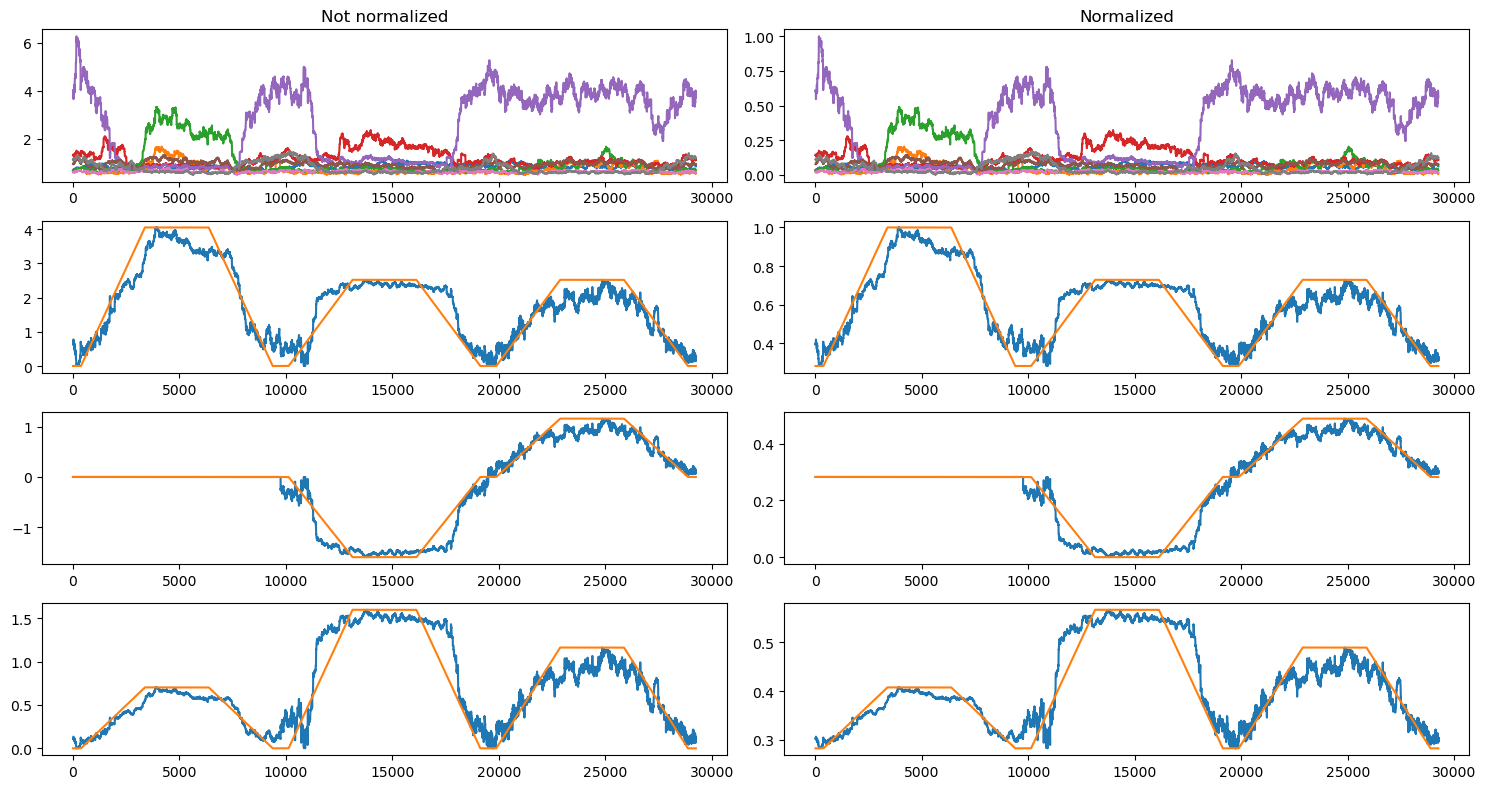

-> rep = 2
X | power: (8, 9750), pinch: (8, 9750), ulnar: (8, 9750)
R | power: (1, 9750), pinch: (1, 9750), ulnar: (1, 9750)


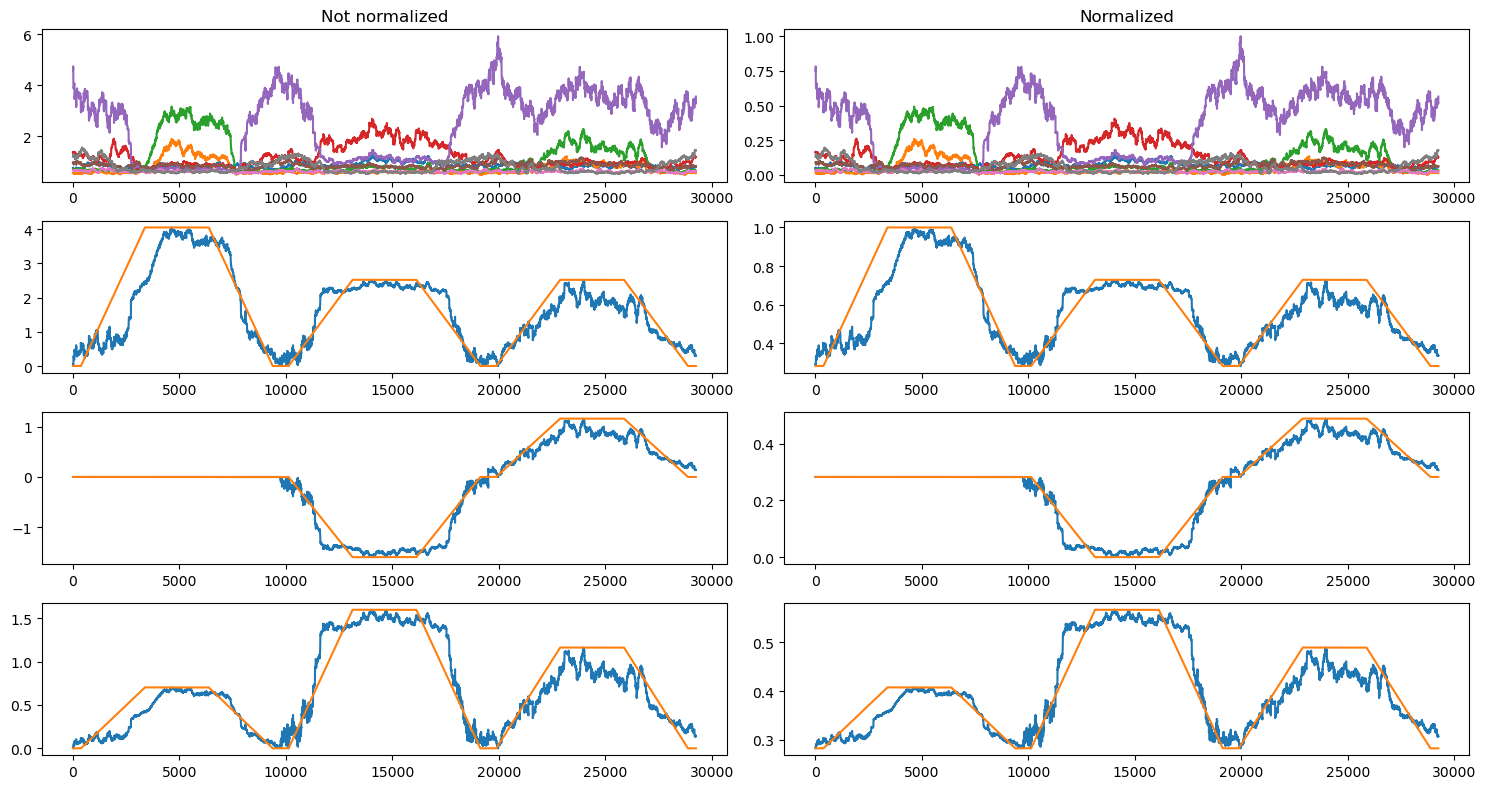

-> rep = 3
X | power: (8, 9750), pinch: (8, 9750), ulnar: (8, 9750)
R | power: (1, 9750), pinch: (1, 9750), ulnar: (1, 9750)


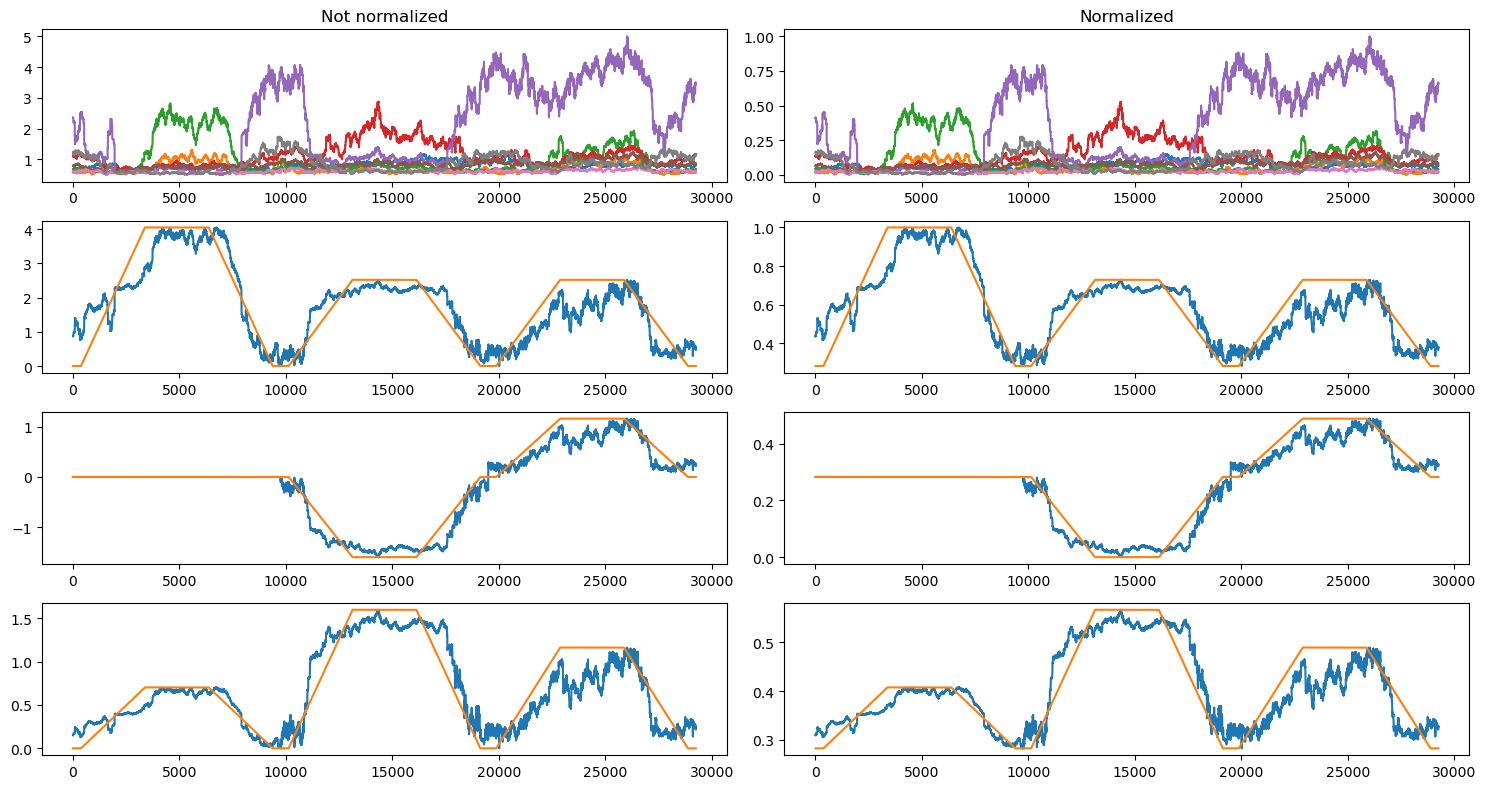

-> rep = 4
X | power: (8, 9750), pinch: (8, 9750), ulnar: (8, 9750)
R | power: (1, 9750), pinch: (1, 9750), ulnar: (1, 9750)


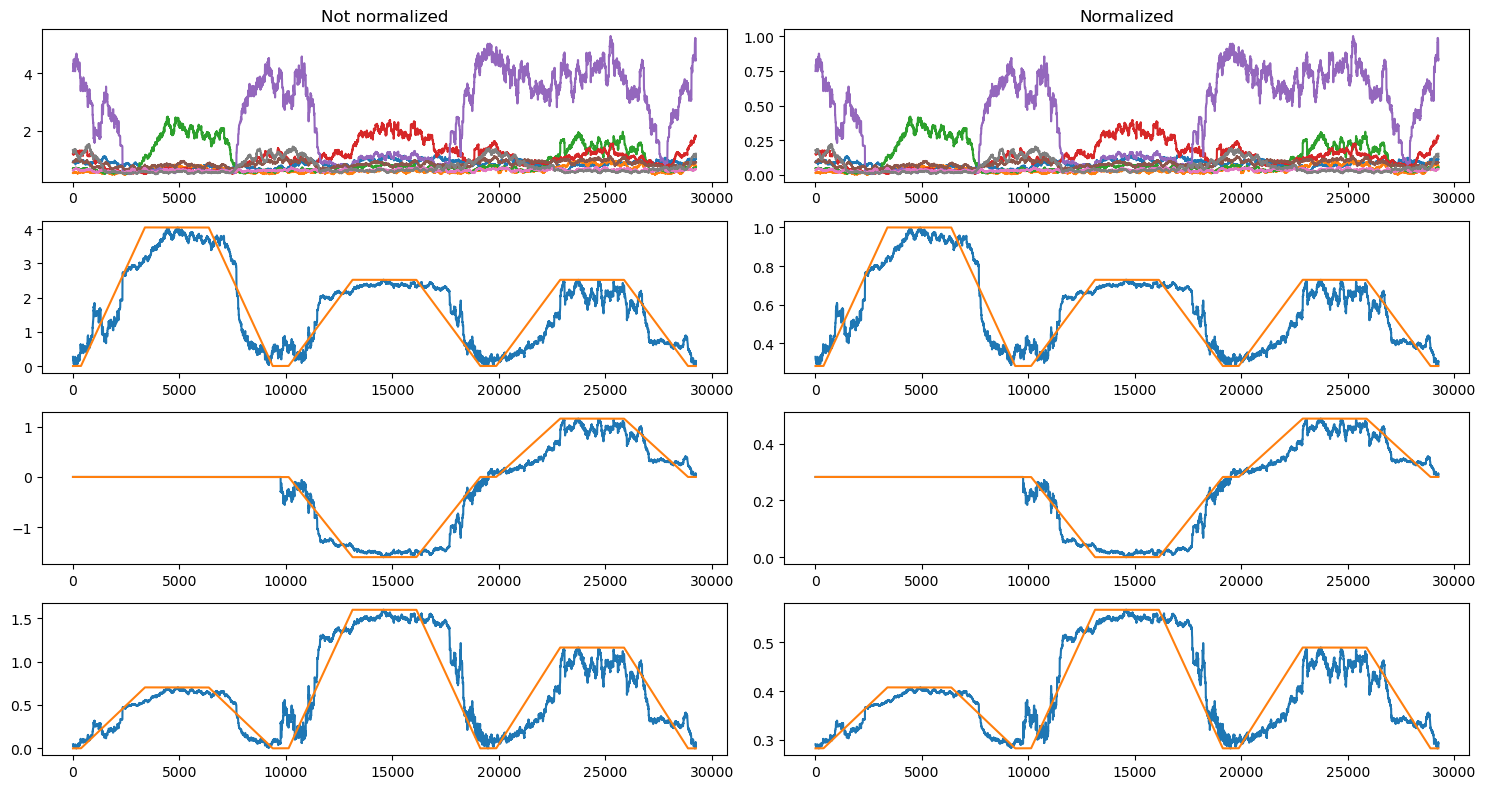

-> rep = 5
X | power: (8, 9750), pinch: (8, 9750), ulnar: (8, 9750)
R | power: (1, 9750), pinch: (1, 9750), ulnar: (1, 9750)


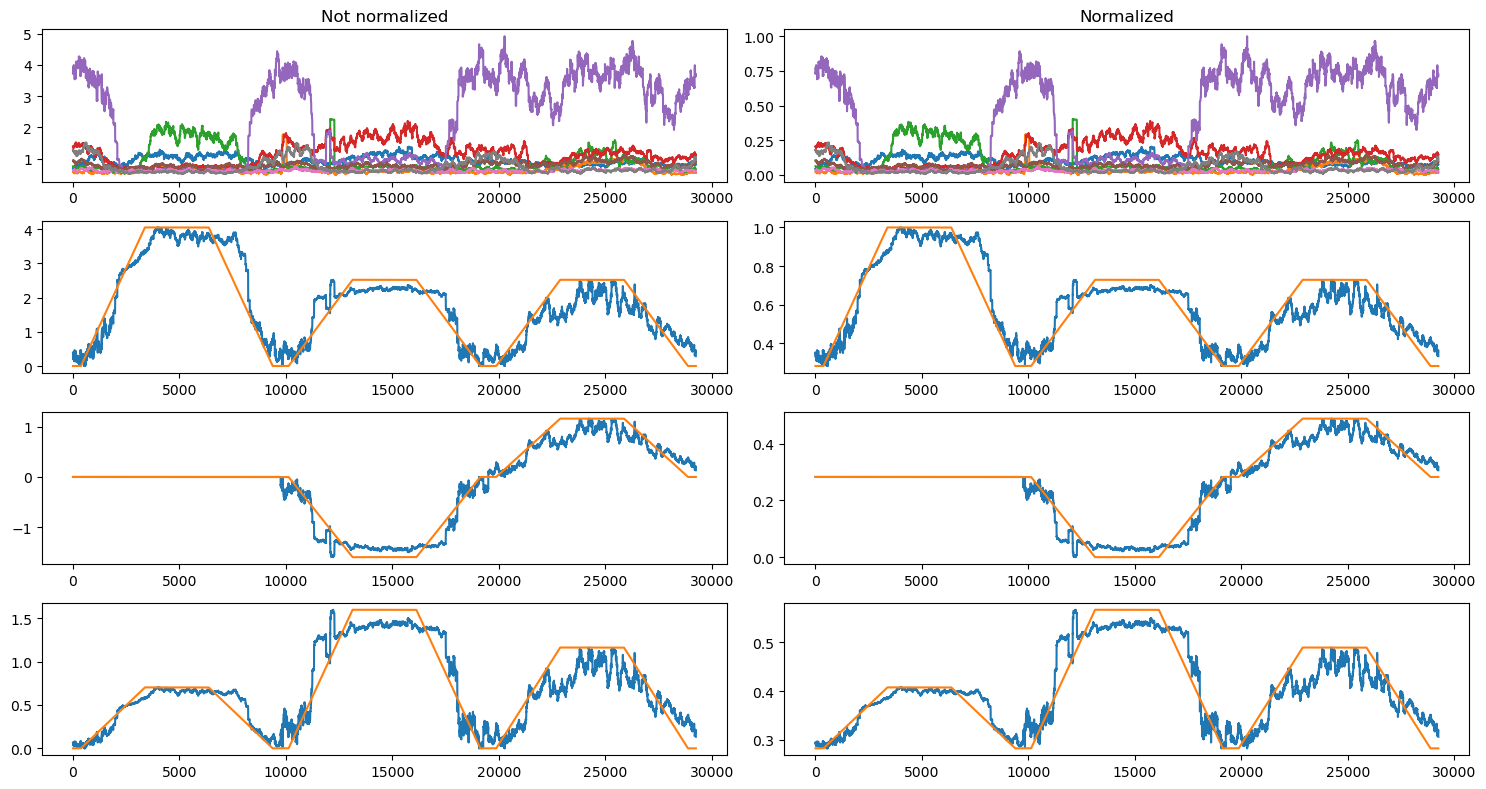

In [1]:
from labeling import *

ALPHA = "ar10" # "ar10", "ub", "berrett"
DATA_PATH = "data"
OUTPUT_PATH = "datasets"

np.random.seed(1)
random.seed(1)

os.makedirs(OUTPUT_PATH, exist_ok=True)
labeler = Labeler(data_path=DATA_PATH, alpha_type=ALPHA, diff_signal=True, n_rep_nmf=10)
data = labeler.run_subj(plot=True)

with open(f"{OUTPUT_PATH}/subj_{ALPHA}.pickle", "wb") as handle:
    pickle.dump(data, handle)

# Training
train the neural network for encoding the input sEMG signals

{'batch_size': 256, 'in_dim': 8, 'out_dim': 3, 'mid_dim': 16, 'num_layers': 4, 'lr': 0.001, 'iters': 10000, 'logging': True, 'device': 'cpu', 'seed': False, 'min_iter': 2000, 'downsample_rate': 4, 'dataset_name': 'ar10', 'greedy_pretraining': False}
Model structure:
layers.0.weight torch.Size([16, 8]) True
layers.0.bias torch.Size([16]) True
layers.2.weight torch.Size([16, 16]) True
layers.2.bias torch.Size([16]) True
layers.4.weight torch.Size([16, 16]) True
layers.4.bias torch.Size([16]) True
layers.6.weight torch.Size([3, 16]) True
layers.6.bias torch.Size([3]) True
**********
hand name: ar10


100%|██████████| 70/70 [00:33<00:00,  2.12it/s, train_loss=0.000459, val_loss=0.000672]

Model saved to checkpoints/ar10_BS256_D16_N4_normal_training.pth


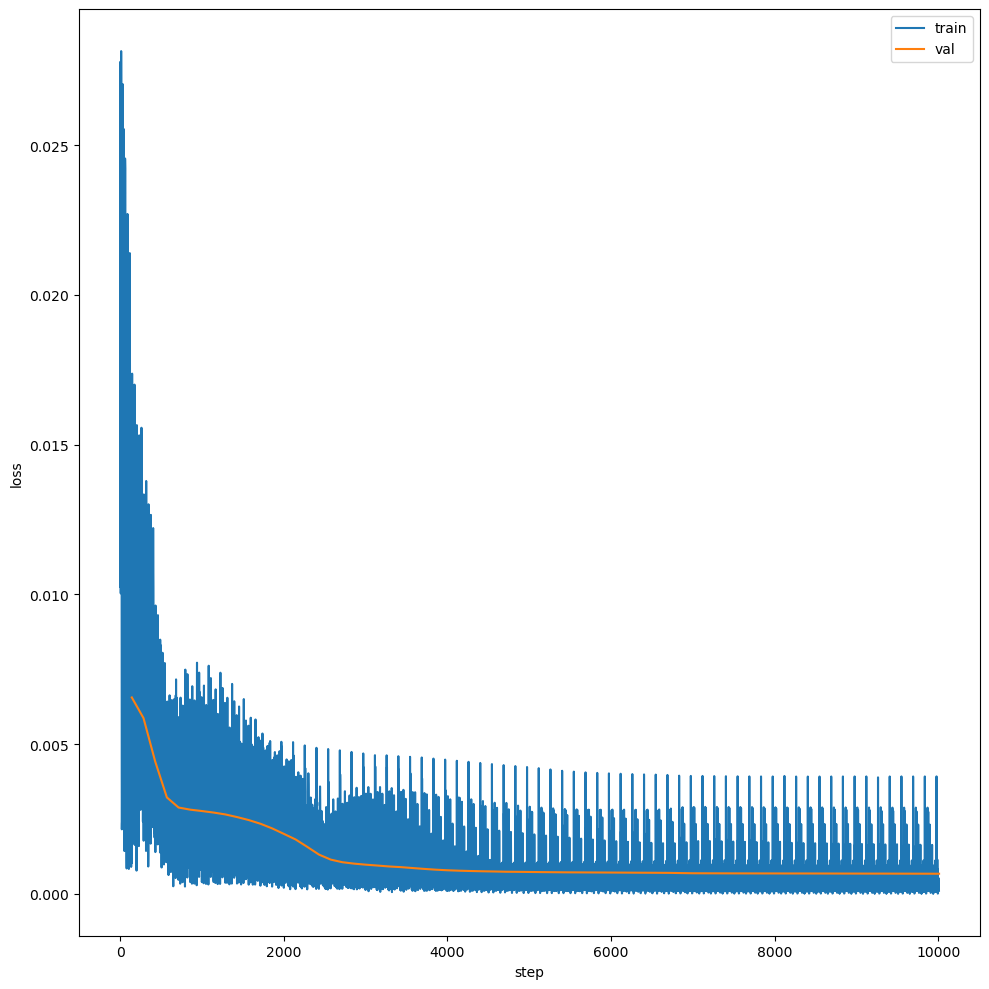

In [2]:
from train import *
import matplotlib.pyplot as plt

base_config = {
    "batch_size": 256,
    "in_dim": 8,
    "out_dim": 3,
    "mid_dim": 16,
    "num_layers": 4,
    "lr": 1e-3,
    "iters": 10000,
    "logging": True,
    "device": "cpu",
    "seed": False,
    "min_iter": 2000,
    "downsample_rate": 4,
    "dataset_name": "ar10",
    "greedy_pretraining": False,
}

print(base_config)

if base_config["seed"] != False:
    set_seeds(base_config["seed"])

dataset_train, dataset_val = get_train_val_dataset(
    f"datasets/subj_{base_config['dataset_name']}.pickle", base_config
)

pretrained_model = None
if base_config["greedy_pretraining"]:
    cprint("**** greedy pre-training ****", "yellow")
    greedy_layerwise_training(
        dataset_train, dataset_val, base_config, num_layers_to_add=base_config["num_layers"] - 2
    )
    pretrained_model = "greedy"

state = normal_training(dataset_train, dataset_val, base_config, pretrained_model=pretrained_model)

logs = state["logs"]
train = logs["train"]
val = logs["val"]
fig = plt.figure(figsize=(10, 10))
plt.plot(train["step"], train["train_loss"], label="train")
plt.plot(val["step"], val["val_loss"], label="val")
plt.xlabel("step")
plt.ylabel("loss")
plt.legend()
plt.tight_layout()
plt.show()


# Predict
use the trained weights for predicting the sEMG signals, checking wrt the reference signal and the label

Model structure:
layers.0.weight torch.Size([16, 8]) True
layers.0.bias torch.Size([16]) True
layers.2.weight torch.Size([16, 16]) True
layers.2.bias torch.Size([16]) True
layers.4.weight torch.Size([16, 16]) True
layers.4.bias torch.Size([16]) True
layers.6.weight torch.Size([3, 16]) True
layers.6.bias torch.Size([3]) True
**********


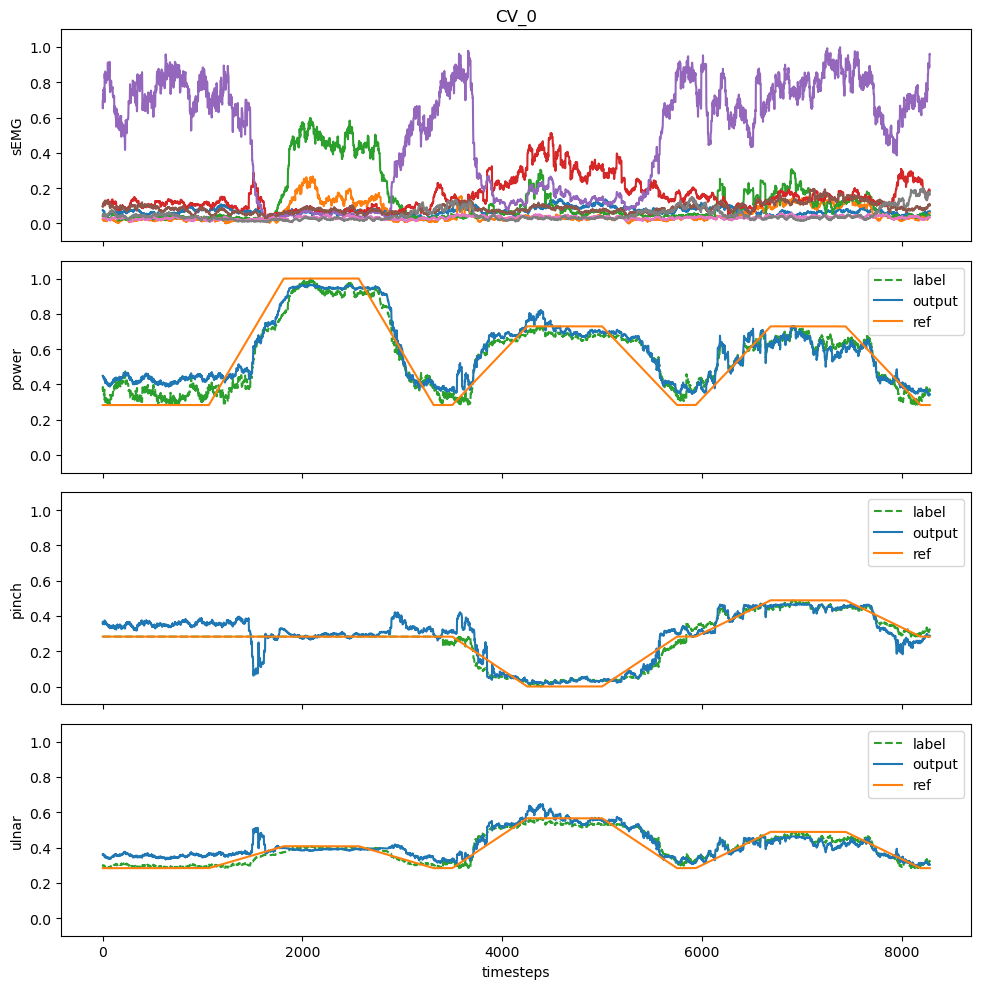

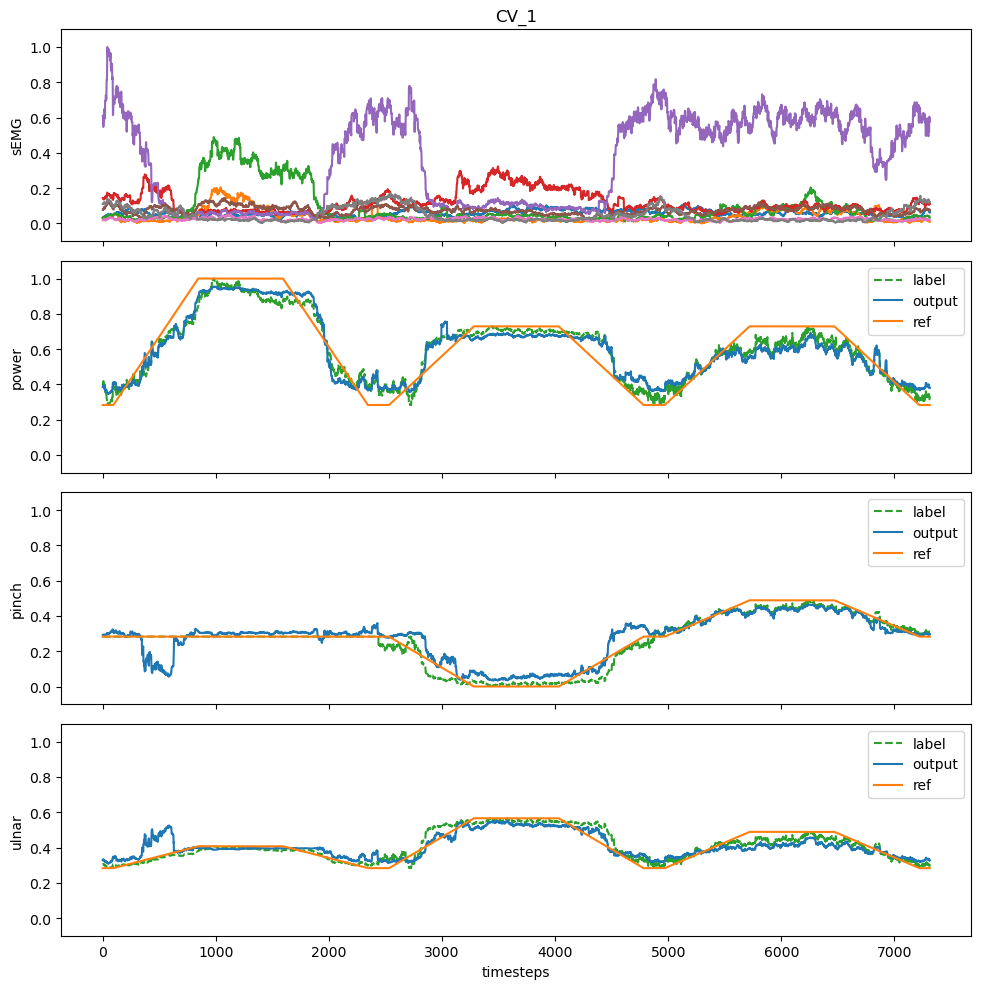

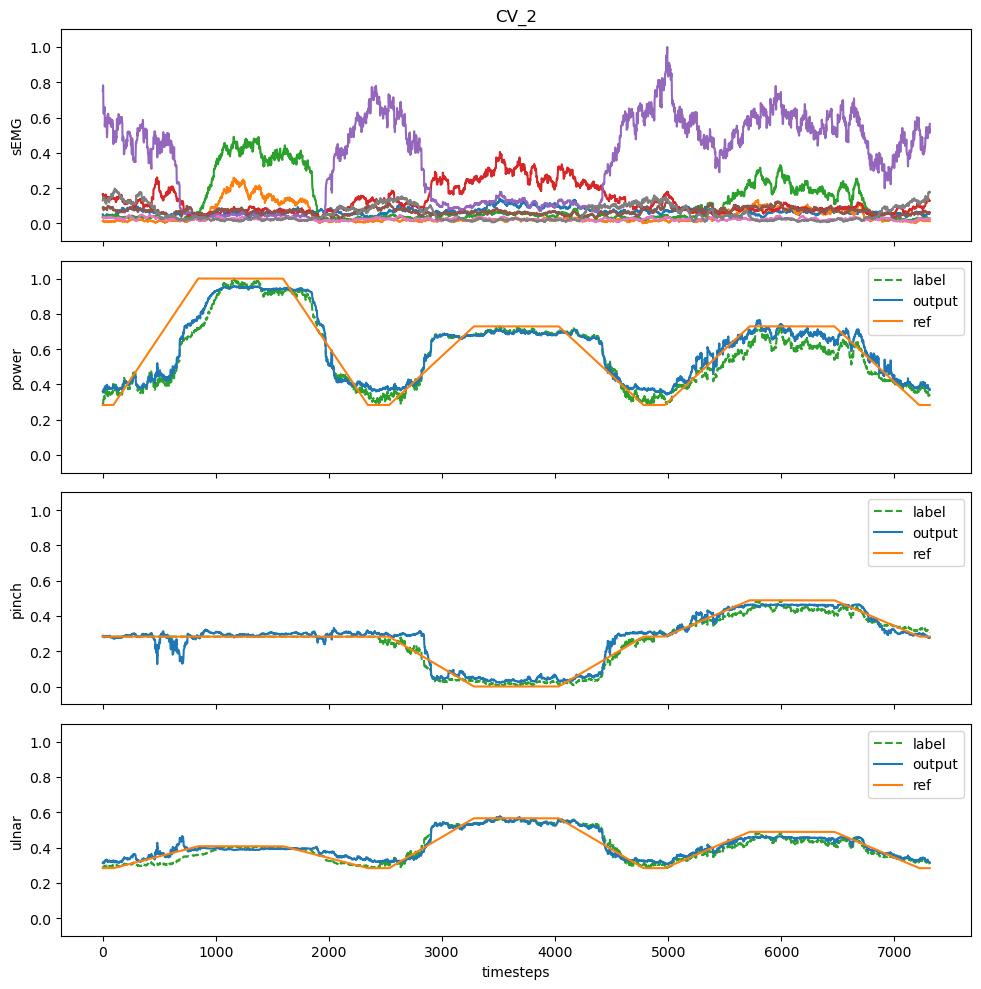

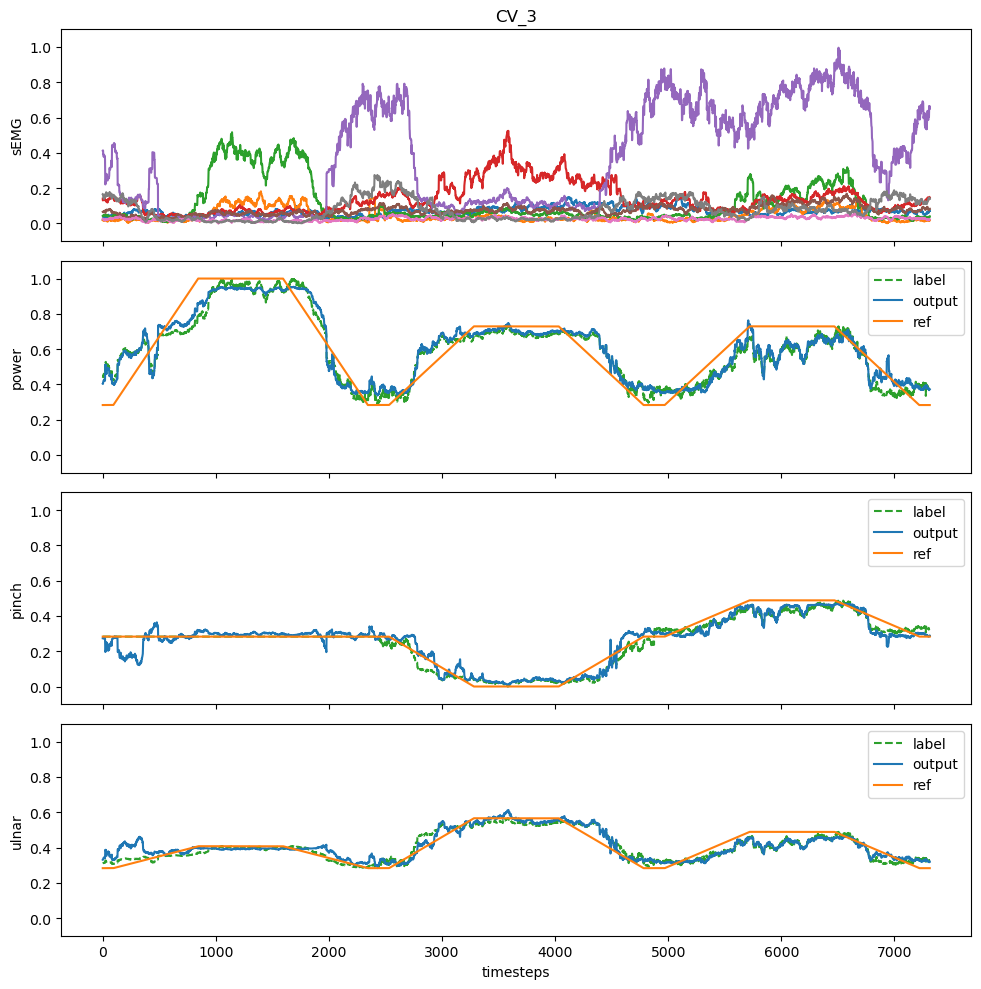

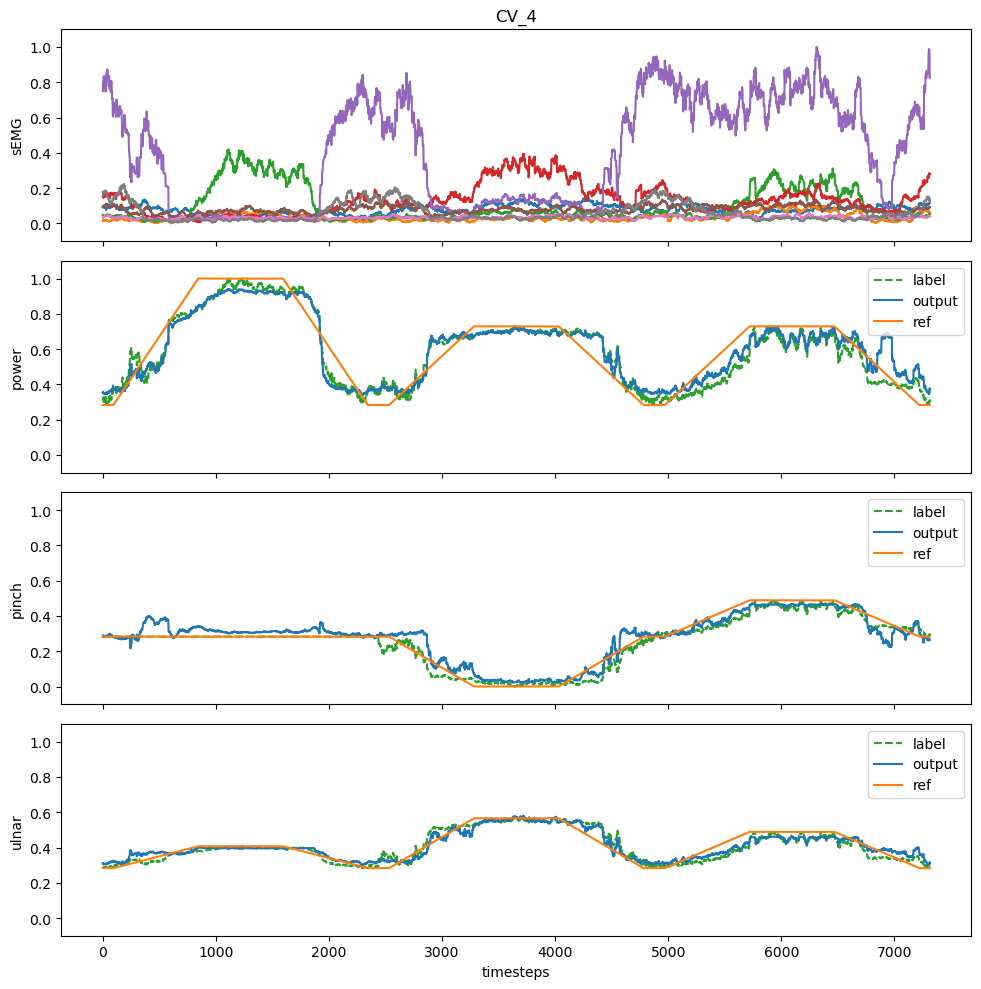

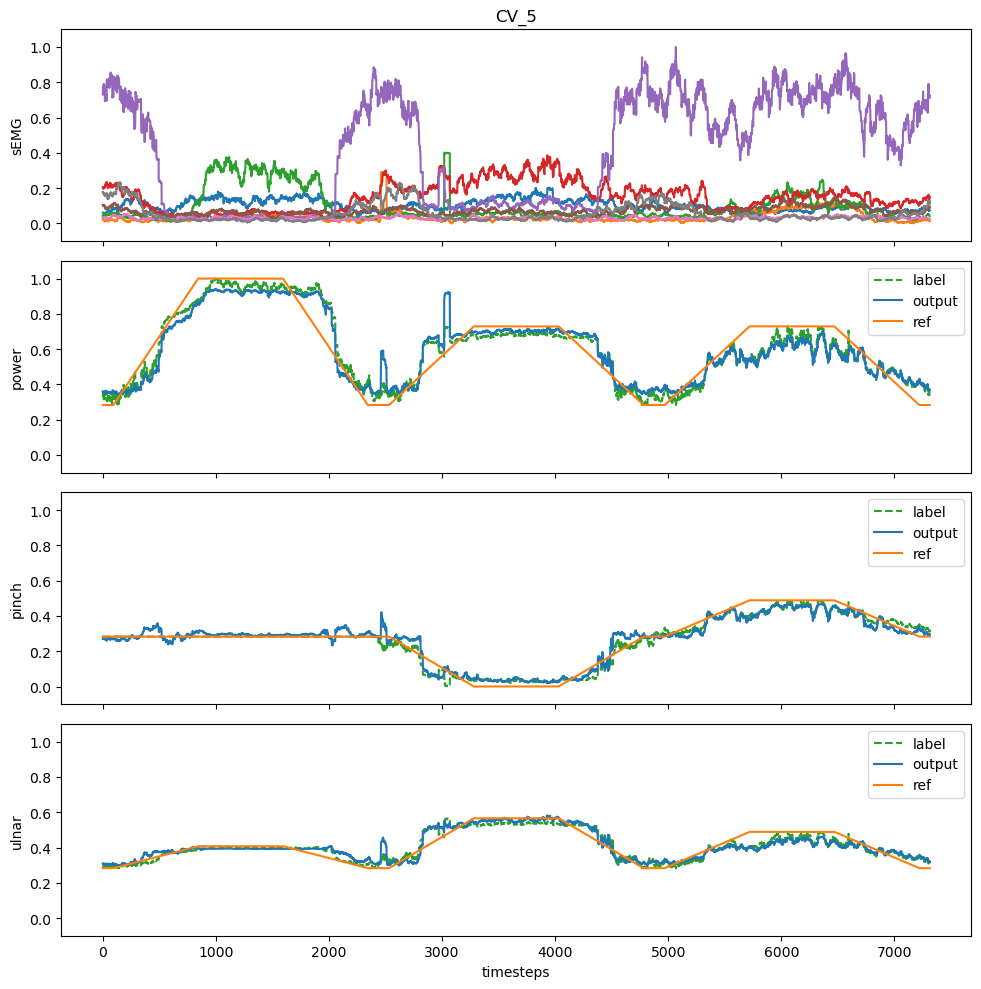

In [3]:
from predict import *

ckpt_path = os.path.join("checkpoints", "ar10_BS256_D16_N4_normal_training.pth")
state = torch.load(ckpt_path)

# DATASET
dataset_path = os.path.join("datasets", f"subj_{state['dataset_name']}.pickle")

# Initialize the model
model = LayerConfigurableMLP(state)
model.build_form_config()
model.load_state_dict(state["model"])
model.eval()

print_model_structure(model)

dataset_cv_out = DataPreProcessing(pickle_path=dataset_path).cross_validation_out()
for out_counter, (_, _, _, val) in enumerate(dataset_cv_out):
    dataset_val = EMGData(val["data"], val["label"], val["ref"])
    data, label, ref, output = [], [], [], []
    loader = torch.utils.data.DataLoader(dataset_val, batch_size=len(dataset_val), num_workers=16, shuffle=False)

    x, l, r = next(iter(loader))
    out = model(x.squeeze(1))

    data = np.array(x.detach().squeeze().numpy())
    label = np.array(l.detach().squeeze().numpy()).T
    ref = np.array(r.detach().squeeze().numpy()).T
    output = np.array(out.detach().squeeze().numpy()).T

    plot_3_out(data, label, ref, output, out_counter)